In [1]:
import numpy as np
import pandas as pd
from scipy import interpolate
from astropy import table
import h5py
import healpy as hp
import glob
import sys
from pathlib import Path
from astropy.cosmology import Planck18 as cosmo
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib.pyplot as plt
import fastparquet

### Load and concat ALL hpix together to plot n(z) of entire 5000 deg^2 footprint of SkySim5000

In [2]:
path_healpix_ids = '/global/homes/y/yoki/roman/desi_like_samples/skysim_5000/data/healpix_ids/id_nums_exclude_edges.npy'
healpix_ids = np.load(path_healpix_ids)
cat_list = []

for hpix in healpix_ids:
    
    input_file_name = f'sim_cat_hpix_{hpix}.parquet'
    sim_cat_path = f'/global/homes/y/yoki/roman/desi_like_samples/skysim_5000/data/sim_data/{input_file_name}'
    sim_cat_loop = pd.read_parquet(path=sim_cat_path)
    cat_list.append(sim_cat_loop)

sim_cat = pd.concat(cat_list)



In [13]:

LOP_NORTH_AREA = 4400
LOP_SOUTH_DECAL_AREA = 8500
LOP_SOUTH_DES_AREA = 1100
TOTAL_DESI_AREA = 14000
DESI_ELG_ZBIN_WIDTH = 0.05
Z_GRID_POINTS = 201
AREA_PER_HEALPIX = 57.071968/17 # Area of 17 healpix divided by 17
ELG_TARG_DENS_AVG = (1930 + 1950 + 1900) / 3



# load in the desi ELG distributions 
path_desi_data = '/global/homes/y/yoki/roman/desi_like_samples/skysim_5000/data/desi_sv_data/desi_elg_ts_zenodo/main-800coaddefftime1200-nz-zenodo.ecsv'
desi_data = table.Table.read(path_desi_data, format='ascii.ecsv')
desi_data.colnames

zmin = desi_data['ZMIN']
zmax = desi_data['ZMAX']
z_bin_centers = (zmin + zmax ) / 2 
zgrid = np.linspace(np.min(zmin), np.max(zmax), Z_GRID_POINTS)
SELECTION_ZBIN_WIDTH = (np.max(zmax) - np.min(zmin)) / (Z_GRID_POINTS - 1)

lop_north = desi_data['ELG_LOP_NORTH']
lop_south_decal = desi_data['ELG_LOP_SOUTH_DECALS']
lop_south_des = desi_data['ELG_LOP_SOUTH_DES']
vlo_north = desi_data['ELG_VLO_NORTH']
vlo_south_decal = desi_data['ELG_VLO_SOUTH_DECALS']
vlo_south_des = desi_data['ELG_VLO_SOUTH_DES']

lop_desi = desi_data['ELG_LOP_DESI']
vlo_desi = desi_data['ELG_VLO_DESI']
weightedavg = (lop_north * LOP_NORTH_AREA + lop_south_decal * LOP_SOUTH_DECAL_AREA  + lop_south_des * LOP_SOUTH_DES_AREA  )/(TOTAL_DESI_AREA)

In [19]:
values, edges = np.histogram(sim_cat['redshift'], bins=np.linspace(0, 2, 41))
values_sim = values/(len(healpix_ids)*AREA_PER_HEALPIX)
z_frac = weightedavg / values_sim


In [45]:
np.max(sim_cat['redshift'])

2.994123936468566

In [56]:
sfr_thres_list = []

for i in range(len(z_bin_centers)):
    print(i)
    this_zmin = zmin[i]
    this_zmax = zmax[i]

    this_cat = sim_cat[np.logical_and(sim_cat['redshift']>this_zmin, sim_cat['redshift']<this_zmax)]
    this_sfr_thres = np.percentile(a = this_cat['sfr_tot'], q = 100-z_frac[i]*100)
    sfr_thres_list.append(this_sfr_thres)

sfr_thres = np.array(sfr_thres_list)
# sfr_thres = np.percentile(a=sim_cat['sfr_tot'], q= 100 - z_frac*100)
path_sfr_thres = str(Path(f'../data/selection_thresholds/elg_sfr_thres.npy'))
np.save(path_sfr_thres, sfr_thres)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [49]:
f_interp = interpolate.interp1d(z_bin_centers, sfr_thres,  fill_value=9E11, bounds_error=False)

z_fine_grid = np.linspace(0,2,20001)
sfr_fine_grid = f_interp(z_fine_grid)

(0.0, 50000000000.0)

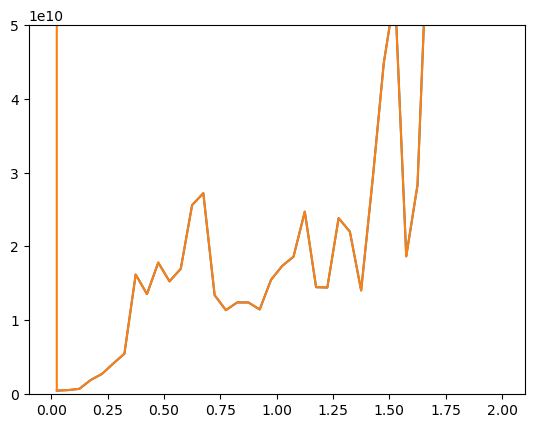

In [50]:
plt.plot(z_bin_centers,sfr_thres)
plt.plot(z_fine_grid, sfr_fine_grid)

plt.ylim(0,0.5e11)

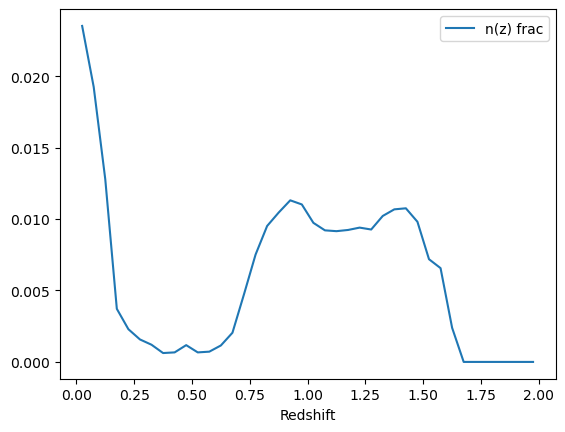

In [51]:

plt.plot(z_bin_centers, z_frac, label = 'n(z) frac')
plt.xlabel('Redshift')
plt.legend()

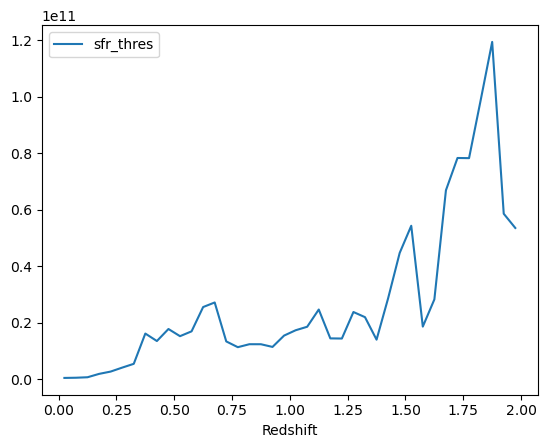

In [52]:

plt.plot(z_bin_centers, sfr_thres, label = 'sfr_thres')
plt.xlabel('Redshift')
plt.legend()

(array([4.85767700e+07, 1.06072853e+08, 1.34565538e+08, 1.73132233e+08,
        1.45321362e+08, 1.09688225e+08, 3.85294370e+07, 2.40000000e+01,
        1.00000000e+00, 1.00000000e+00]),
 array([-5.03352943e-04,  2.98959376e-01,  5.98422105e-01,  8.97884834e-01,
         1.19734756e+00,  1.49681029e+00,  1.79627302e+00,  2.09573575e+00,
         2.39519848e+00,  2.69466121e+00,  2.99412394e+00]),
 <BarContainer object of 10 artists>)

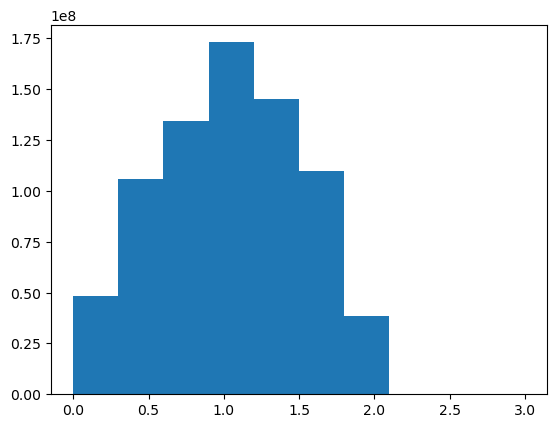

In [53]:
# plt.hist(sim_cat['redshift'])

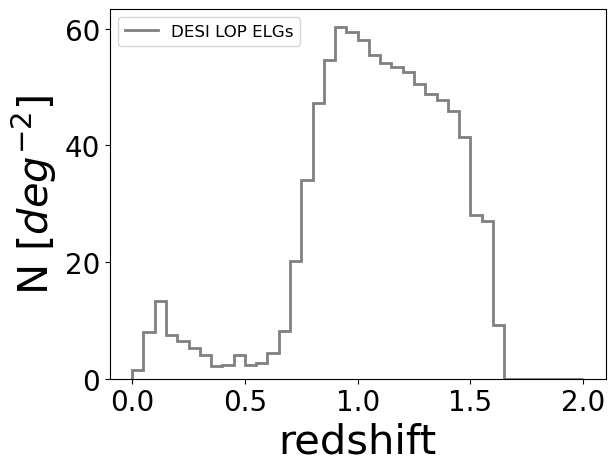

In [24]:


fig, ax = plt.subplots()
ax.stairs(weightedavg, edges, linewidth=2, color ='grey', label= 'DESI LOP ELGs')
#ax.stairs(values_sim), edges, linewidth=2, color='blue', label='SkySim5000')
# ax.axvline(x=1.10,ls='--', color='black')
# ax.axvline(x=1.60,ls='--', color='black')
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
ax.set_xlabel('redshift', fontsize=30)
ax.set_ylabel('N [$deg^{-2}]$', fontsize=30)
ax.legend(loc='upper left', fontsize=12)